In [14]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model
from keras import backend as K
from keras.optimizers import SGD
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import (ImageDataGenerator, Iterator,
                                       array_to_img, img_to_array, load_img)
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import sys, os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [15]:
%matplotlib inline

In [16]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [47]:
train_data_dir = './data/CollisionData/'

img_width, img_height = 224, 224
nb_train_samples = 730 
nb_validation_samples = 181
epochs = 10
batch_size = 16

if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [63]:
model = Sequential() 
model.add(Conv2D(32, (2, 2), input_shape = input_shape)) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size =(2, 2))) 
  
model.add(Conv2D(32, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size =(2, 2))) 
  
model.add(Conv2D(64, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size =(2, 2))) 
  
model.add(Flatten()) 
model.add(Dense(64)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1)) 
model.add(Activation('sigmoid')) 
# model = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu', 
#            input_shape=(img_width, img_height ,3)),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

  
model.compile(loss ='binary_crossentropy', 
                     optimizer ='adam', 
                   metrics =['accuracy']) 

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 223, 223, 32)      416       
_________________________________________________________________
activation_1 (Activation)    (None, 223, 223, 32)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 110, 110, 32)      4128      
_________________________________________________________________
activation_2 (Activation)    (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 54, 54, 64)        8256      
__________

In [116]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    ) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation') # set as validation data



history = model.fit_generator(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size) 
  

Found 730 images belonging to 2 classes.
Found 181 images belonging to 2 classes.
Epoch 1/10
45/45 [==============================] - 25s 553ms/step - loss: 0.2038 - acc: 0.9153 - val_loss: 0.1225 - val_acc: 0.9545
Epoch 2/10
45/45 [==============================] - 25s 545ms/step - loss: 0.2083 - acc: 0.9053 - val_loss: 0.1914 - val_acc: 0.8920
Epoch 3/10
45/45 [==============================] - 24s 538ms/step - loss: 0.2153 - acc: 0.8984 - val_loss: 0.2087 - val_acc: 0.9489
Epoch 4/10
45/45 [==============================] - 24s 528ms/step - loss: 0.2008 - acc: 0.9228 - val_loss: 0.1489 - val_acc: 0.9432
Epoch 5/10
45/45 [==============================] - 23s 515ms/step - loss: 0.1917 - acc: 0.9214 - val_loss: 0.1038 - val_acc: 0.9659
Epoch 6/10
45/45 [==============================] - 23s 509ms/step - loss: 0.2091 - acc: 0.9028 - val_loss: 0.3811 - val_acc: 0.8295
Epoch 7/10
45/45 [==============================] - 23s 502ms/step - loss: 0.2201 - acc: 0.9214 - val_loss: 0.0835 - val

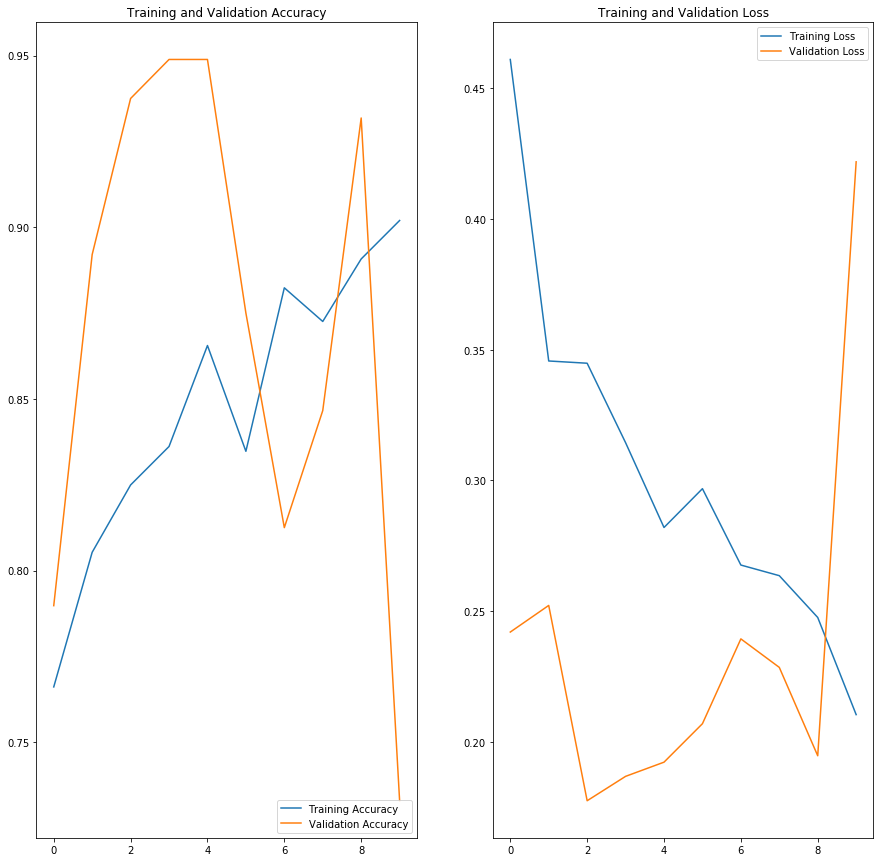

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
from keras.utils import Sequence


probabilities = model.predict_generator(generator=validation_generator)
print probabilities

[[0.21809983]
 [0.22955434]
 [0.2012765 ]
 [0.2836817 ]
 [0.2547597 ]
 [0.14842704]
 [0.07757489]
 [0.05875047]
 [0.11388455]
 [0.05024119]
 [0.05248326]
 [0.13483587]
 [0.1249916 ]
 [0.11633806]
 [0.07741672]
 [0.09850774]
 [0.04940189]
 [0.06146287]
 [0.17915449]
 [0.16390496]
 [0.05760812]
 [0.0634296 ]
 [0.30110297]
 [0.06688762]
 [0.3793963 ]
 [0.42792287]
 [0.03465081]
 [0.08275127]
 [0.0413157 ]
 [0.16947222]
 [0.05646431]
 [0.17468442]
 [0.06160548]
 [0.0463919 ]
 [0.04876186]
 [0.07160415]
 [0.04082521]
 [0.06917253]
 [0.04141472]
 [0.04706867]
 [0.1058775 ]
 [0.83242047]
 [0.9553575 ]
 [0.994099  ]
 [0.529302  ]
 [0.9620846 ]
 [0.15060917]
 [0.4143887 ]
 [0.9875965 ]
 [0.9796409 ]
 [0.9844208 ]
 [0.43645388]
 [0.39488134]
 [0.5572221 ]
 [0.9930902 ]
 [0.9312892 ]
 [0.2346224 ]
 [0.43194577]
 [0.34679812]
 [0.53531986]
 [0.98802626]
 [0.9912612 ]
 [0.9466419 ]
 [0.7175943 ]
 [0.82713944]
 [0.29206738]
 [0.7944456 ]
 [0.6547157 ]
 [0.8840471 ]
 [0.8288965 ]
 [0.9943921 ]
 [0.90

In [19]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
class_labels = list(validation_generator.class_indices.keys())  

In [20]:
report = metrics.classification_report(y_true, y_pred, target_names=class_labels)
print(report)  

                  precision    recall  f1-score   support

     NoCollision       0.45      1.00      0.62        41
CollisionOrClose       1.00      0.64      0.78       140

     avg / total       0.87      0.72      0.74       181



In [21]:
mat = confusion_matrix(y_true, y_pred)
print mat

[[41  0]
 [51 89]]


In [22]:
def plotImages1(images_arr, y1, y2, row_size):
    fig, axes = plt.subplots(1, row_size, figsize=(20,20))
    axes = axes.flatten()
    for img, l, p, ax in zip(images_arr, y1, y2, axes):
        ax.imshow(img)
        ax.set_title("Label:"+str(int(l))+", Pred:"+str(int(p)))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

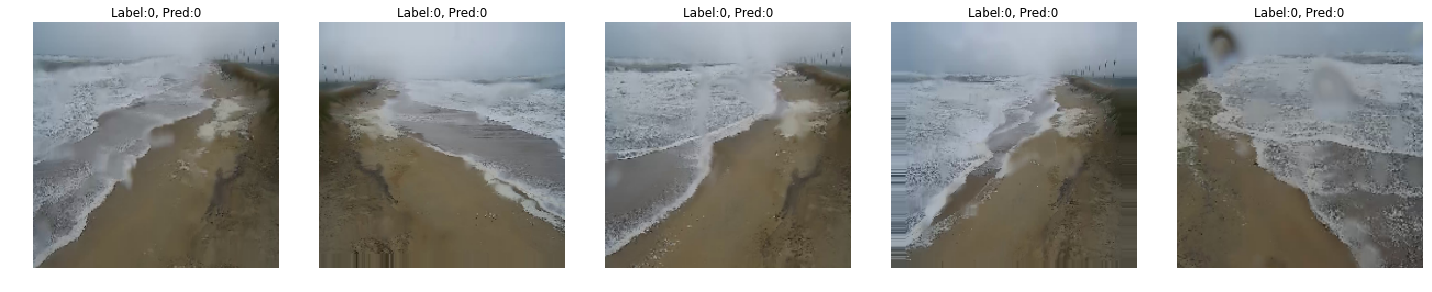

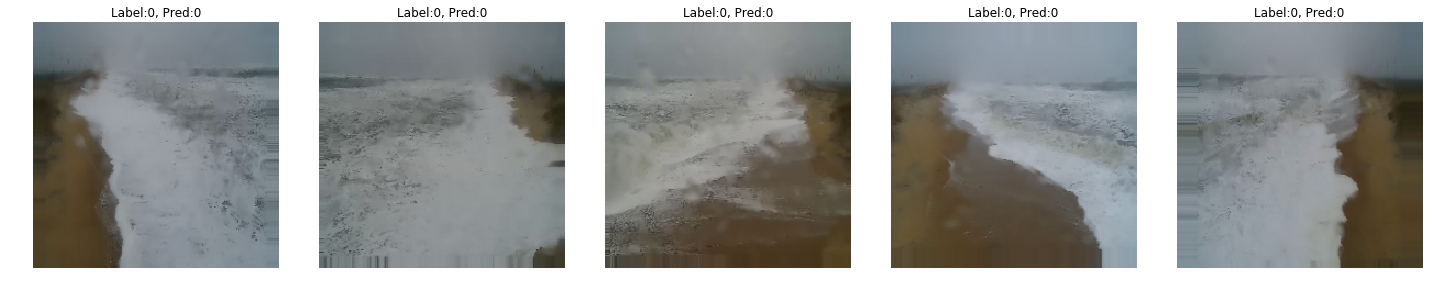

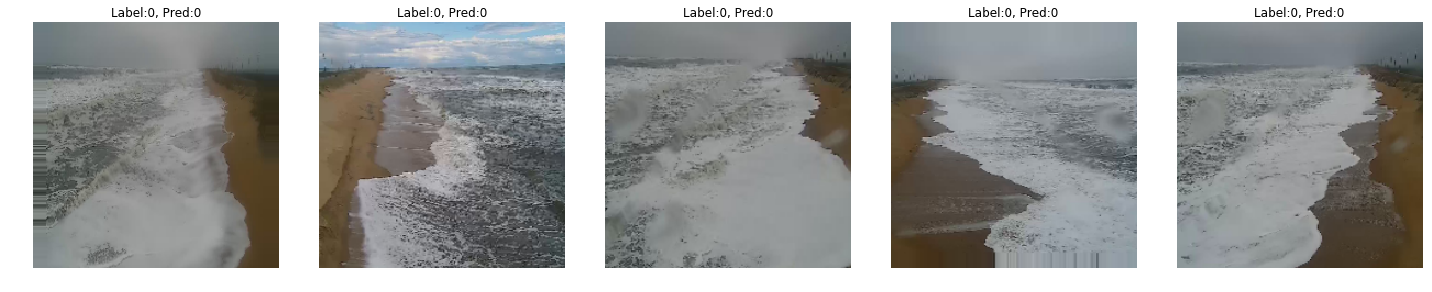

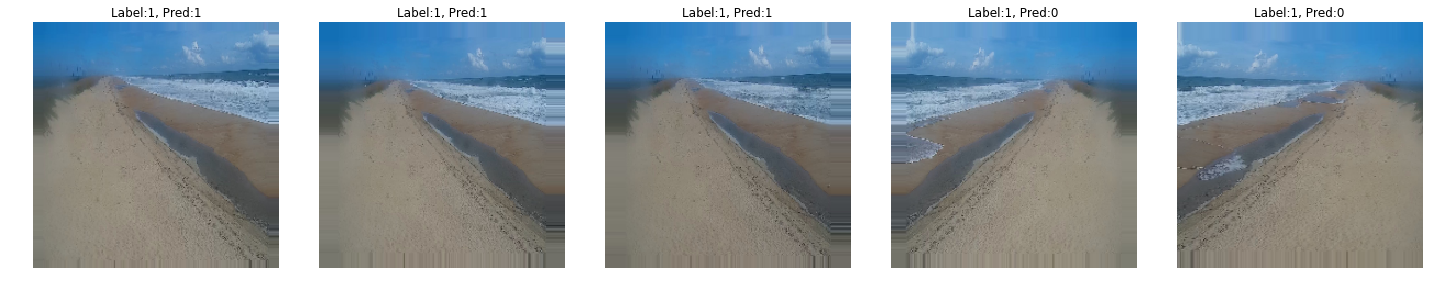

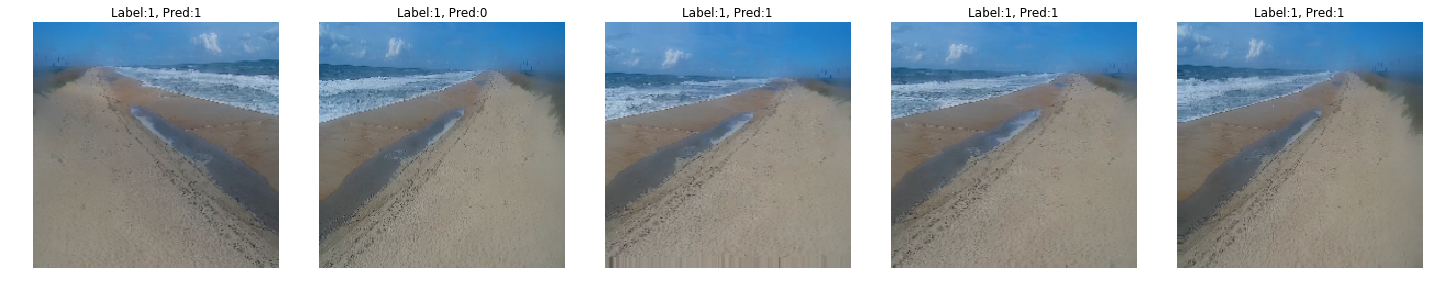

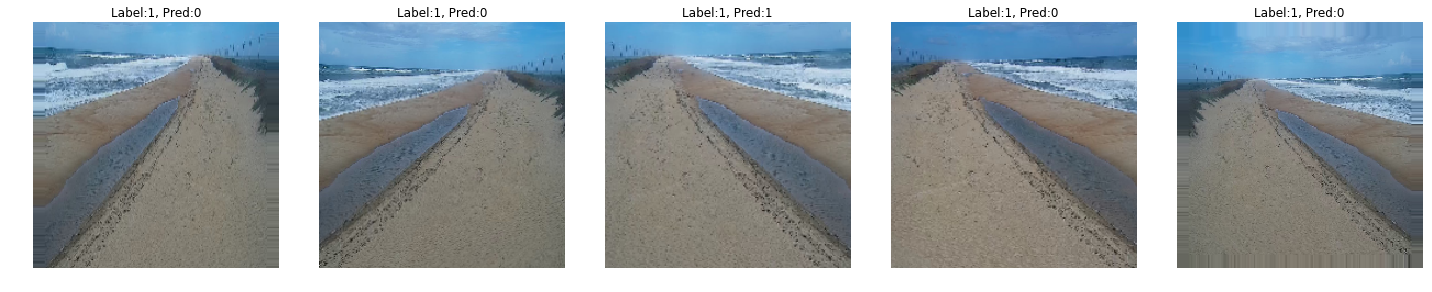

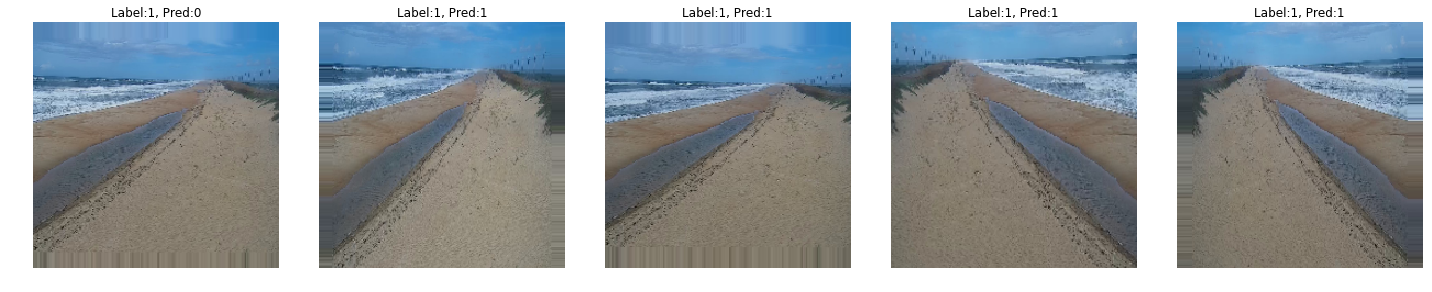

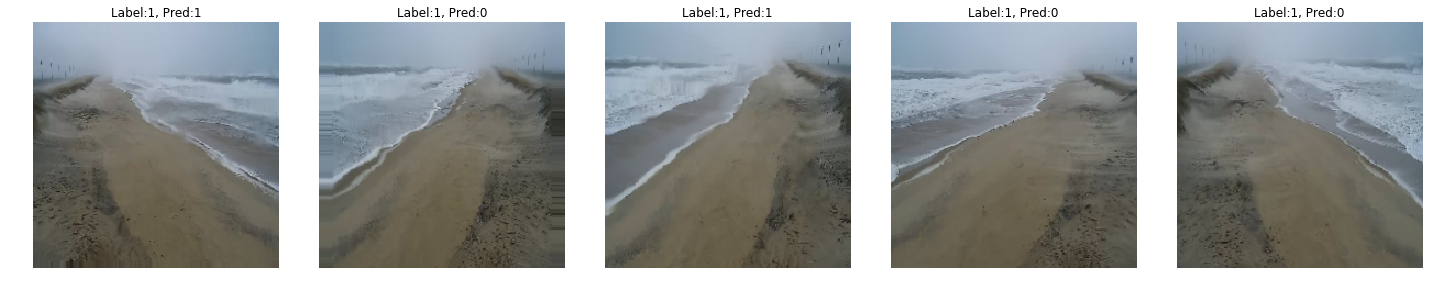

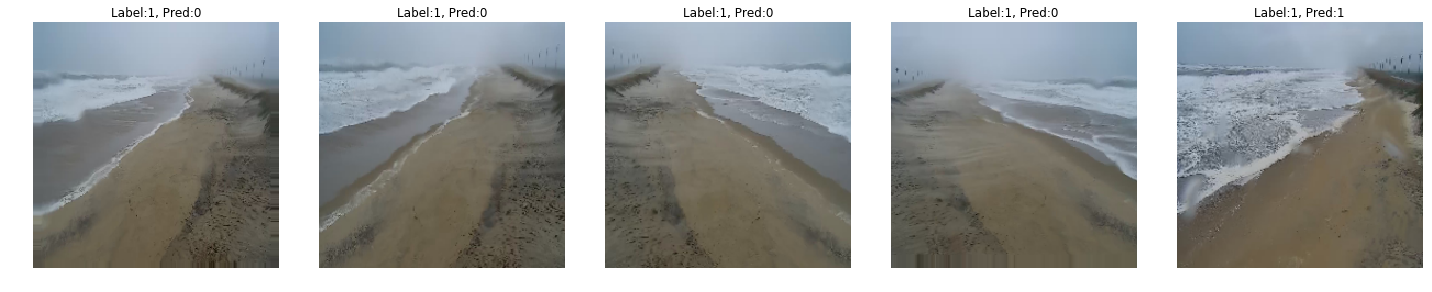

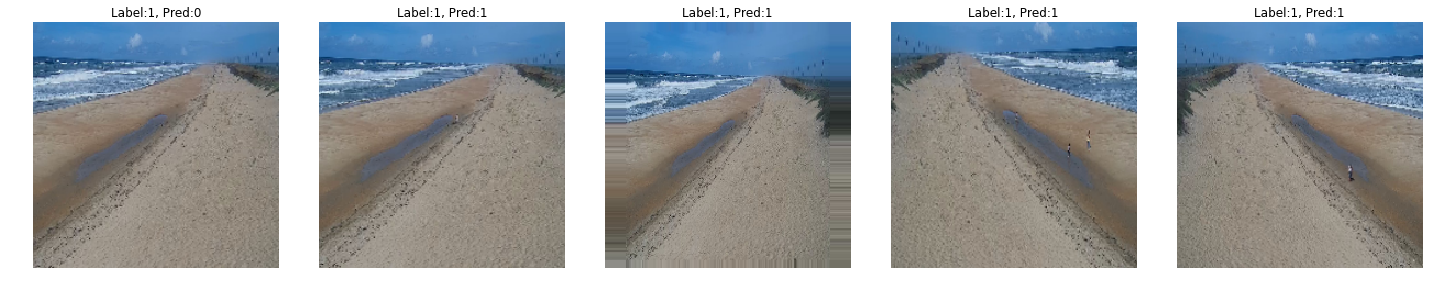

In [24]:
cnt = 0
row_size = 5
validation_generator.reset()
fig=plt.figure(figsize=(20,20))

ax = []
for i in range(10):
    x,y = next(validation_generator)
    img = x[:row_size]
    y_label = y[:row_size]
    y_predicted = y_pred[cnt:cnt+row_size]
    plotImages1(img, y_label, y_predicted, row_size)
    cnt += 16

In [197]:
labels = (validation_generator.class_indices)

In [198]:
labels

{'CollisionOrClose': 0, 'NoCollision': 1}